# Readability Regressor

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import joblib
import os
from pathlib import Path
import sys

from sklearn.metrics import mean_squared_error

## Define Files and Directories

In [2]:
# Input files
data_dir = Path('../input/commonlitreadabilityprize')
train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'



In [3]:
# Data files for readability formulas
dalechall_file = '../input/the-new-dalechall-familiar-words-list/DaleChallEasyWordList.txt'
spache_file = '../input/spache-familiar-words-list/SpacheFamiliarWordList.txt'


In [4]:
train_df = pd.read_csv(train_file, index_col='id')
test_df = pd.read_csv(test_file, index_col='id')
print(f'Train size:{train_df.shape}. Test size:{test_df.shape}')
train_df.head()

Train size:(2834, 5). Test size:(7, 3)


,url_legal,license,excerpt,target,standard_error
id,,,,,
c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


## Calculate Classic Metrics for Readability
Based on:

https://clickhelp.com/software-documentation-tool/user-manual/readability-metrics.html

https://readabilityformulas.com/

### Common Classic Metrics:
Most readability formulas (**Fry, Flesch-Kincaid, Gunning Fog, and others**) are based on weighted combination of:
- ASL: Average sentence length (number of words in a sentence, excluding numbers).
- ASW: Average number of syllables per word.

Some other formulas (**SMOG, Linsear Write**) are similar to the above, but instead of average word length, they count number of long words (Polysyllables - 3 or more syllables). Some more simple formulas use average characters count per word instead of syllables.

### Formulas based on list of common words:

**The New Dale-Chall Formula** and Spache Readability Formula use a predefined set of "common" words and the ratio of "unfamiliar" or "difficult" words (PDW) and words per sentence (ASL).

Difficult words in Dale-Chall formula are words that do not appear on a specially designed list of common words familiar to most 4th-grade students - around 3000 words (https://readabilityformulas.com/articles/dale-chall-readability-word-list.php).

**The Spache Formula** considers “unfamiliar words” as words that 3rd grade and below do not recognize. The Spache list comprises of 925 familiar words (https://readabilityformulas.com/articles/spache-formula-word-list.php).

The Spache Formula is best used to calculate the difficulty of text that falls at the 3rd grade level or below, while the New Dale-Chall Formula is best used for texts that falls at the 4th grade level or above.

**Words considering "familiar"**:

- Words appearing on the common words list.

- Variants of words appearing on the list that have regular verb form endings – ing, -ed, -es.

- Plural and Possessive endings of nouns from the list.

- First Names.

- Single letters standing alone as words. E.g., ‘C is the third letter of the alphabets.’

**‘Difficult Words’:**

- Words not appearing on the "familiar" list or its variants as specified above.

- Variants of words appearing on the list that have irregular verb form endings – unless those variant forms also appear on the list.

- Variants of words appearing on the list that have adverbial, comparative, or superlative endings – ly, -er, -est.

- Words not appearing on the list are counted only once, even if they appear later with other endings.


**Bottom line Features Extraction:**

We'll extract the following features from the text:

- ASL: Average Sentence Length.
- ASW: Average Syllables per Word.
- ROP: Ratio Of Polysyllables (percentage of 3 or more syllables words in total words)
- RDC: Ratio of Dale-Chall difficult words
- ROS: Ratio Of Spache difficult words

In [5]:
import spacy

try:
    import syllapy
except ImportError as e:
    !pip install syllapy -q
    import syllapy
    
nlp = spacy.load('en_core_web_sm')

In [6]:
with open(dalechall_file) as f:
    dalechall_list = f.read().lower().split()
    
with open(spache_file) as f:
    spache_list = f.read().lower().split()

In [7]:
# ASL: Average Sentence Length.
# ASW: Average Syllables per Word.
# ROP: Ratio Of Polysyllables (percentage of 3 or more syllables words in total words)
# RDC: Ratio of Dale-Chall difficult words
# ROS: Ratio Of Spache difficult words

def count_difficult_words (word, easy_words_list, difficult_words_dict):
    word_lemma = word.lemma_.lower()
    if (
        word.ent_type_ != 'PERSON'
        and word.text.lower() not in easy_words_list
        and word_lemma not in easy_words_list
    ):
        try:
            difficult_words_dict[word_lemma] += 1
        except:
            difficult_words_dict[word_lemma] = 1
    return difficult_words_dict

def extract_readability_features(in_df):
    ASL_list, ASW_list, ROP_list, RDC_list, ROS_list = [], [], [], [], []
    total_words_list, num_sentences_list = [], []
    df = in_df.copy()
    
    for txt in df.excerpt:    
        doc = nlp(txt)
        sents = len(list(doc.sents)) # Number of sentences
        difficult_words_dale = {}
        difficult_words_spach = {}
        word_count = 0
        syllables_count = 0
        polysyllables_count = 0
        for token in doc:
            if token.is_alpha:
                word_count += 1
                syllables = syllapy.count(token.text)
                syllables_count += syllables
                if syllables>=3:
                    polysyllables_count+=1
                difficult_words_dale = count_difficult_words (token, dalechall_list, difficult_words_dale)
                difficult_words_spach = count_difficult_words (token, spache_list, difficult_words_spach)
                
        ASL_list.append(word_count/sents)
        ASW_list.append(syllables_count/word_count)
        ROP_list.append(polysyllables_count/word_count)
        RDC_list.append(len(difficult_words_dale) / word_count)
        ROS_list.append(len(difficult_words_spach) / word_count)
        num_sentences_list.append(sents)
        total_words_list.append(word_count)
        
    df['ASL'] = ASL_list
    df['ASW'] = ASW_list
    df['ROP'] = ROP_list
    df['RDC'] = RDC_list
    df['ROS'] = ROS_list
    df['num_sentences'] = num_sentences_list
    df['total_words'] = total_words_list
    return df


In [8]:
train_df_new = extract_readability_features(train_df)
train_df_new.head()

,url_legal,license,excerpt,target,standard_error,ASL,ASW,ROP,RDC,ROS,num_sentences,total_words
id,,,,,,,,,,,,
c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,16.454545,1.337017,0.082873,0.127072,0.187845,11,181
85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,11.133333,1.401198,0.071856,0.089820,0.161677,15,167
b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,15.181818,1.347305,0.077844,0.071856,0.149701,11,167
dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,33.400000,1.275449,0.035928,0.077844,0.209581,5,167
37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,30.200000,1.125828,0.006623,0.019868,0.026490,5,151


In [9]:
test_df_new = extract_readability_features(test_df)
test_df_new.head()

,url_legal,license,excerpt,ASL,ASW,ROP,RDC,ROS,num_sentences,total_words
id,,,,,,,,,,
c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...,18.625000,1.328859,0.033557,0.080537,0.187919,8,149
f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...,17.900000,1.240223,0.027933,0.039106,0.072626,10,179
0df072751,NaN,NaN,It was a bright and cheerful scene that greete...,15.636364,1.325581,0.052326,0.069767,0.127907,11,172
04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...,25.714286,1.811111,0.266667,0.227778,0.255556,7,180
0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...,27.666667,1.783133,0.253012,0.307229,0.367470,6,166


In [10]:
train_df_new.sort_values(by=['target']).head(10)

,url_legal,license,excerpt,target,standard_error,ASL,ASW,ROP,RDC,ROS,num_sentences,total_words
id,,,,,,,,,,,,
4626100d8,NaN,NaN,"The commutator is peculiar, consisting of only...",-3.676268,0.623621,22.125000,1.666667,0.163842,0.192090,0.265537,8,177
493b80aa7,NaN,NaN,The Dunwich horror itself came between Lammas ...,-3.668360,0.571404,28.000000,1.515306,0.107143,0.219388,0.290816,7,196
fe44cbd14,NaN,NaN,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.642892,0.644398,31.000000,1.720430,0.193548,0.231183,0.290323,6,186
284eaa5ad,NaN,NaN,As to surface-slope its measurement—from nearl...,-3.639936,0.603819,27.285714,1.717277,0.193717,0.240838,0.314136,7,191
9e9eacb49,NaN,NaN,"The tree is dioecious, bearing male catkins on...",-3.636834,0.606822,25.857143,1.524862,0.132597,0.171271,0.209945,7,181
466e33a64,NaN,NaN,The copper even of such a conductor has been m...,-3.596751,0.567050,29.166667,1.560000,0.120000,0.131429,0.200000,6,175
ee7d40251,NaN,NaN,We have frequent inquiries as to the best mean...,-3.585369,0.588952,49.500000,1.454545,0.111111,0.151515,0.222222,4,198
f18969199,https://en.wikipedia.org/wiki/Molecular_nanote...,CC BY-SA 3.0,Molecular nanotechnology (MNT) is a technology...,-3.549190,0.643309,26.000000,2.314103,0.371795,0.320513,0.371795,6,156
85b41606e,NaN,NaN,"As soon as the plate is dry, a positive cliché...",-3.543987,0.609348,38.200000,1.486911,0.109948,0.178010,0.246073,5,191


In [11]:
train_df_new.sort_values(by=['target']).tail(10)

,url_legal,license,excerpt,target,standard_error,ASL,ASW,ROP,RDC,ROS,num_sentences,total_words
id,,,,,,,,,,,,
bae209b89,https://www.africanstorybook.org/,CC BY 4.0,"After a night of heavy rain, a group of friend...",1.432604,0.615058,10.315789,1.346939,0.030612,0.040816,0.096939,19,196
46599d29c,NaN,NaN,"The stockings hung by the chimney, and the tal...",1.436503,0.560820,10.944444,1.208122,0.005076,0.030457,0.076142,18,197
c14f4a3c3,NaN,NaN,Once upon a time there were three bears who li...,1.444385,0.623120,18.666667,1.202381,0.023810,0.029762,0.047619,9,168
62dceff46,NaN,NaN,"One day her mother said to her: ""Come, Red Rid...",1.465055,0.607107,33.400000,1.203593,0.047904,0.023952,0.071856,5,167
09c41e31e,NaN,NaN,There was once a young man who spent all his t...,1.465592,0.639018,14.818182,1.306748,0.061350,0.049080,0.092025,11,163
016913371,https://www.africanstorybook.org/,CC BY 4.0,Grandma's garden was wonderful. It was full of...,1.467665,0.599600,9.750000,1.394872,0.092308,0.046154,0.097436,20,195
7a1d484be,https://www.africanstorybook.org/,CC BY 4.0,More people came to the bus stop just before 9...,1.541672,0.606997,6.478261,1.201342,0.020134,0.026846,0.040268,23,149
8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,"Every day, Emeka's father took him to school i...",1.583847,0.624776,9.142857,1.286458,0.067708,0.020833,0.052083,21,192
849971671,https://www.africanstorybook.org/,CC BY 4.0,"For her last birthday, Sisanda had a special t...",1.597870,0.596349,11.642857,1.343558,0.085890,0.055215,0.104294,14,163


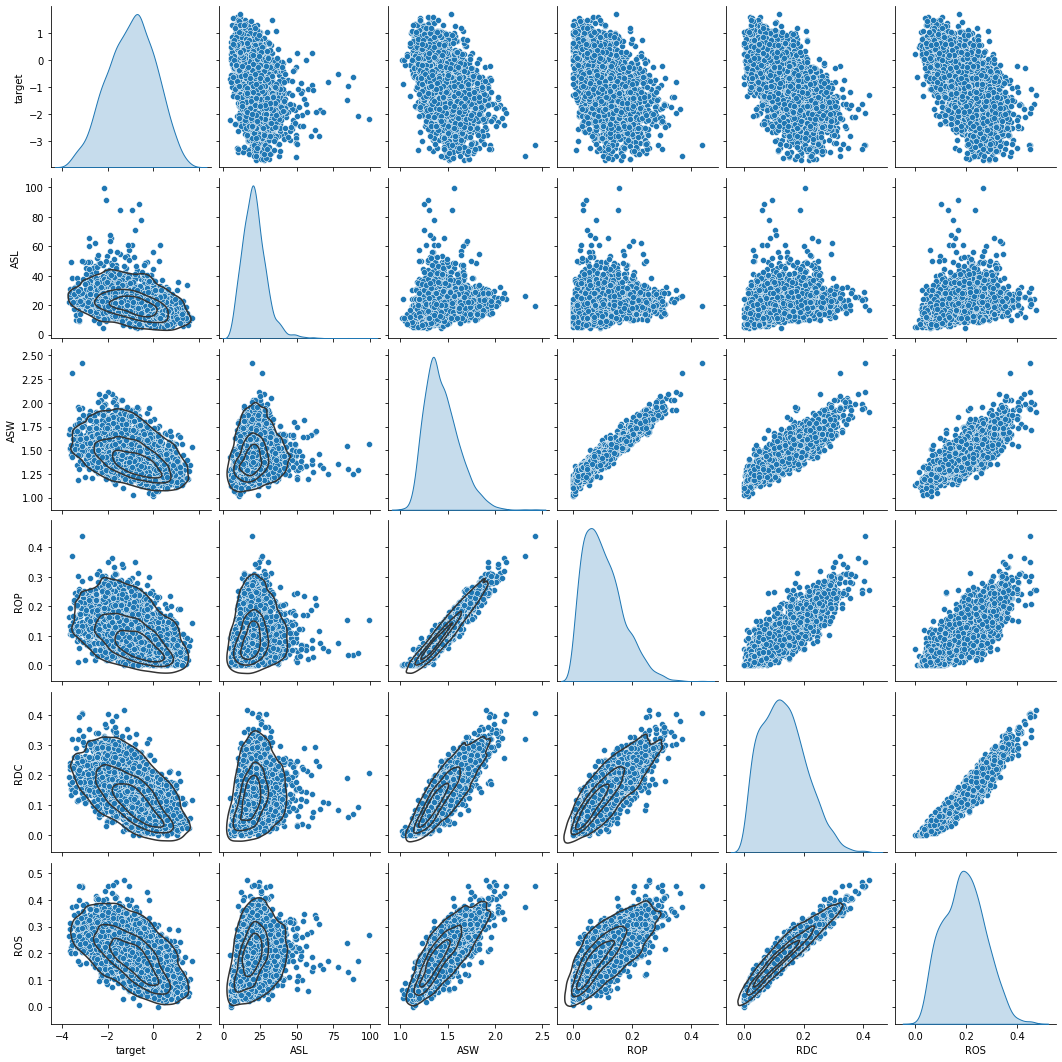

In [12]:
# Plot pairs correlations
from matplotlib import pyplot as plt
import seaborn as sns

g = sns.pairplot(train_df_new, vars = ['target','ASL','ASW','ROP','RDC','ROS'], diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

In [13]:
# Ususally low target (= high complex readability score) has longer words, but some excerpts has relatively short words (low ROP),
# but those words are considered complex (with high ROS, RDC).

len(train_df_new[(train_df_new['ROP']<0.05) & (train_df_new['target']<-2.5)])

5

In [14]:
for excerpt in train_df_new[(train_df_new['ROP']<0.05) & (train_df_new['target']<-2.5)]['excerpt']:
    print (excerpt)
    print ('--------')

But here Nature fulfilled her want of speech and spoke for her. The murmur of the brook, the voice of the village folk, the songs of the boatmen, the crying of the birds and rustle of trees mingled and were one with the trembling of her heart. They became one vast wave of sound which beat upon her restless soul. This murmur and movement of Nature were the mute girl's language; that speech of the dark eyes, which the long lashes shaded, was the language of the world about her. From the trees, where the cicadas chirped, to the quiet stars there was nothing but signs and gestures, weeping and sighing. And in the deep mid-noon, when the boatmen and fisherfolk had gone to their dinner, when the villagers slept and birds were still, when the ferryboats were idle, when the great busy world paused in its toil and became suddenly a lonely, awful giant, then beneath the vast impressive heavens there were only mute Nature and a girl, sitting very silent,—one under the spreading sunlight, the othe